# Compare adaptive algorithm against non-adaptive algorithm curve

In [31]:
import json
from matplotlib import pyplot as plt
import numpy as np

In [32]:
RESULT_FOLDER = "./results"
SEED = 46

llms = ["gemma2_9b", "llama3.1_8b", "llama3.2_3b", "mistral_7b", "qwen2.5_7b", "qwen3_4b"]
rms = ["fsfairx_rm", "mistral_rm"]

llm_name = llms[0]
rm_name = rms[1]

llm_mapping = {
    "gemma2_9b": "google/gemma-2-9b-it", 
    "llama3.1_8b": "meta-llama/Llama-3.1-8B-Instruct",
    "llama3.2_3b": "meta-llama/Llama-3.2-3B-Instruct",
    "mistral_7b": "mistralai/Mistral-7B-Instruct-v0.3",
    "qwen2.5_7b": "Qwen/Qwen2.5-7B-Instruct",
    "qwen3_4b": "Qwen/Qwen3-4B-Instruct-2507",
}

rm_mapping = {
    "fsfairx_rm": "sfairXC/FsfairX-LLaMA3-RM-v0.1", 
    "mistral_rm": "weqweasdas/RM-Mistral-7B"
}

In [33]:
def read_cost_analysis(llm_name, rm_name):
    data = []
    file_name = f"{RESULT_FOLDER}/cost_range_{llm_name}_{rm_name}_{SEED}.jsonl"
    print(file_name)
    lines = []
    with open(file_name, "r") as f:
        lines = f.readlines()

    for line in lines:
        data.append(json.loads(line))

    return data

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_revenue_comparison(costs_shortlist, NAs, As, K, factor, llm_name=None, rm_name=None):
    """
    Create improved visualization comparing non-adaptive and Pandora's Box algorithms.
    
    Parameters:
    -----------
    costs_shortlist : list
        List of tuples (index, cost) for different cost scenarios
    NAs : list
        Non-adaptive algorithm results
    As : list
        Adaptive (Pandora's Box) algorithm results
    K : int
        Number of iterations/samples
    factor : float
        Factor for reward calculation
    """

    llm_label = llm_mapping.get(llm_name, llm_name)
    rm_label = rm_mapping.get(rm_name, rm_name)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Main Title
    fig.text(0.5, 0.98, 'Profit Comparison: Non-Adaptive vs Pandora\'s Box Algorithm', 
             fontsize=16, fontweight='bold', ha='center', va='top')
    
    # --- CHANGE 1: Combined the two subtitles into a single line ---
    fig.text(0.5, 0.92, f'LLM: {llm_label}  |  Reward Model: {rm_label}', 
             fontsize=12, ha='center', va='top')
    
    # Store statistics for summary
    stats = []
    
    # First pass to calculate common y-axis limits for consistency
    y_min, y_max = float('inf'), float('-inf')
    
    for i, c in costs_shortlist:
        ys = []
        for j in range(len(NAs[0])):
            y = np.mean([NAs[l][j]["mean"] * factor - NAs[l][j]["sample_count"] * c for l in range(K)])
            ys.append(y)
        ystar = np.mean([2*As[l][i]["revenue"] for l in range(K)])
        
        current_min = min(min(ys), ystar)
        current_max = max(max(ys), ystar)
        y_min = min(y_min, current_min)
        y_max = max(y_max, current_max)
    
    # Add padding to y-axis
    y_padding = (y_max - y_min) * 0.1
    y_min -= y_padding
    y_max += y_padding

    res = []
    
    # Create each subplot
    for idx, (i, c) in enumerate(costs_shortlist):
        ax = axes[idx]
        
        # Calculate data points for non-adaptive algorithm
        xs = []
        ys = []
        for j in range(len(NAs[0])):
            x = np.mean([NAs[l][j]["sample_count"] for l in range(K)])
            y = np.mean([2*(NAs[l][j]["mean"] - NAs[l][j]["sample_count"]*c) for l in range(K)])
            xs.append(x)
            ys.append(y)
        
        # Calculate Pandora's Box performance
        ystar = np.mean([2*As[l][i]["revenue"] for l in range(K)])
        
        # Calculate max values
        max_na = np.max(ys)
        adaptive_scaled = ystar
        
        # Store statistics
        optimal_samples = xs[np.argmax(ys)]
        stats.append({
            'cost': c,
            'pandora': ystar,
            'max_non_adaptive': max_na,
            'optimal_samples': optimal_samples,
            'reward_cost_ratio': 0.5 / c
        })
        
        # Plot non-adaptive points (blue dots forming a curve)
        ax.scatter(xs, ys, s=20, c='blue', alpha=0.7, 
                   label='Non-Adaptive' if idx == 0 else "")
        
        # Connect dots with a line for better visualization
        sorted_indices = np.argsort(xs)
        ax.plot([xs[i] for i in sorted_indices], 
                [ys[i] for i in sorted_indices], 
                'b-', alpha=0.3, linewidth=1)
        
        # Plot Pandora's Box performance (red horizontal line)
        ax.axhline(y=adaptive_scaled, color='red', linestyle='--', linewidth=2, 
                   label='Pandora\'s Box' if idx == 0 else "")
        
        # Mark the optimal point for non-adaptive
        ax.scatter([optimal_samples], [max_na], s=100, c='green', 
                   marker='*', zorder=5, 
                   label='Optimal Non-Adaptive' if idx == 0 else "")
        
        # Add text annotations for max values (bottom right corner)
        ax.text(0.98, 0.15, f'Non-Adaptive Max: {max_na:.3f}', 
                transform=ax.transAxes, fontsize=9, ha='right',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        
        ax.text(0.98, 0.05, f'Adaptive Max: {adaptive_scaled:.3f}', 
                transform=ax.transAxes, fontsize=9, ha='right',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

        res.append(adaptive_scaled/max_na)
        
        # Formatting
        ax.set_ylim(-1, +1)
        ax.set_xlabel('Sample Count', fontsize=14)
        if idx == 0:
            ax.set_ylabel('Profit (Utility - Total Cost)', fontsize=14)
        
        # Add title with cost and reward/cost ratio
        ax.set_title(f'Cost/Utility Ratio = {c/0.5}', 
                     fontsize=14, pad=10)
        
        # Grid for better readability
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        ax.set_facecolor('#f9f9f9')
        
        # Add shading to show positive/negative revenue regions
        ax.axhspan(0, +1, alpha=0.1, color='green')
        ax.axhspan(-1, 0, alpha=0.1, color='red')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        
        # Format tick labels
        ax.tick_params(axis='both', which='major', labelsize=9)
        
    # --- CHANGE 2: Moved the legend to be vertical and on the right-hand side ---
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.98, 0.5), 
               ncol=1, frameon=True, fontsize=10, title='Algorithm Type')
    
    # --- CHANGE 3: Adjusted layout to make space for the right-hand legend ---
    # The 'rect' argument [left, bottom, right, top] is adjusted. 
    # Reducing the 'right' value from 1.0 to 0.97 creates space for the legend.
    # The 'top' value is increased slightly as there is more vertical space now.
    plt.tight_layout(rect=[0, 0, 0.97, 0.85]) 
    
    plt.show()
    return fig, stats, res

gemma2_9b fsfairx_rm
./results5/cost_range_gemma2_9b_fsfairx_rm_46.jsonl


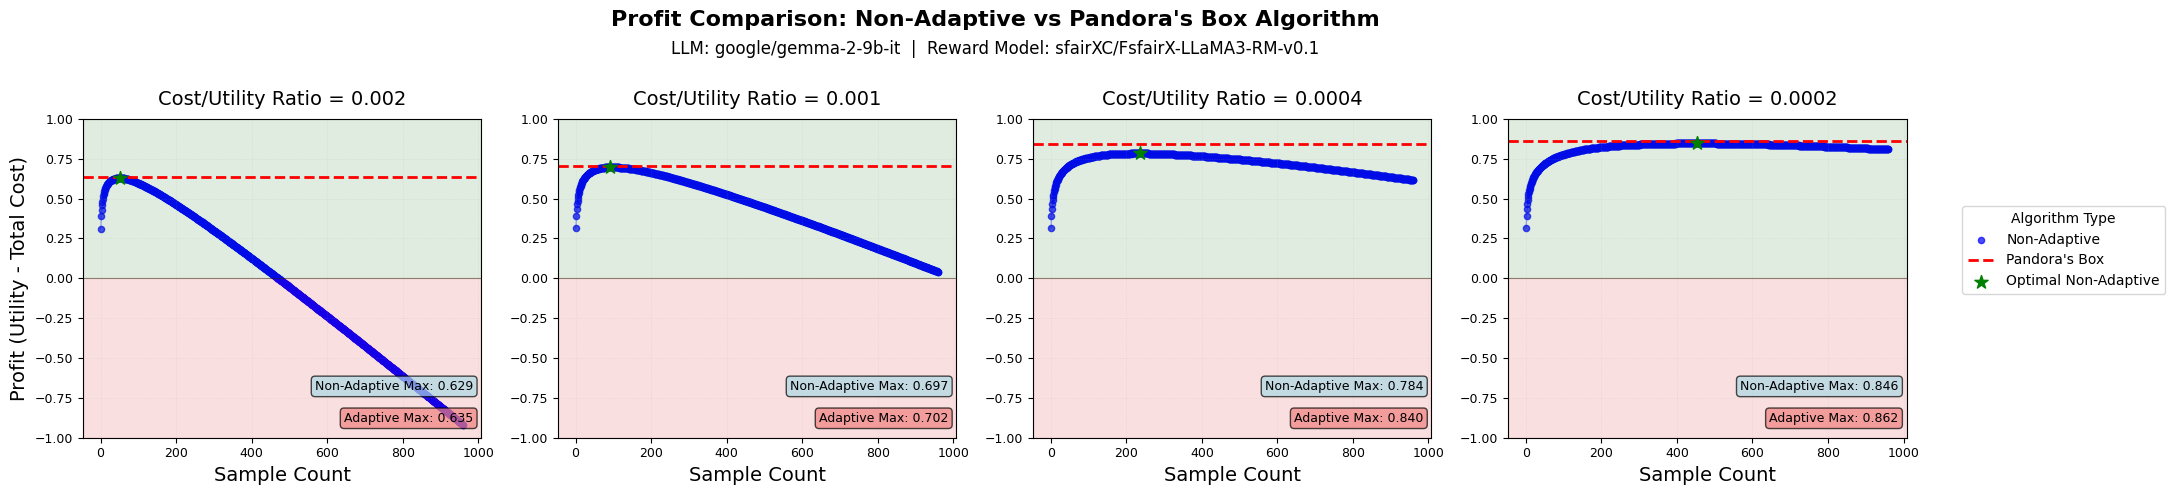

gemma2_9b mistral_rm
./results5/cost_range_gemma2_9b_mistral_rm_46.jsonl


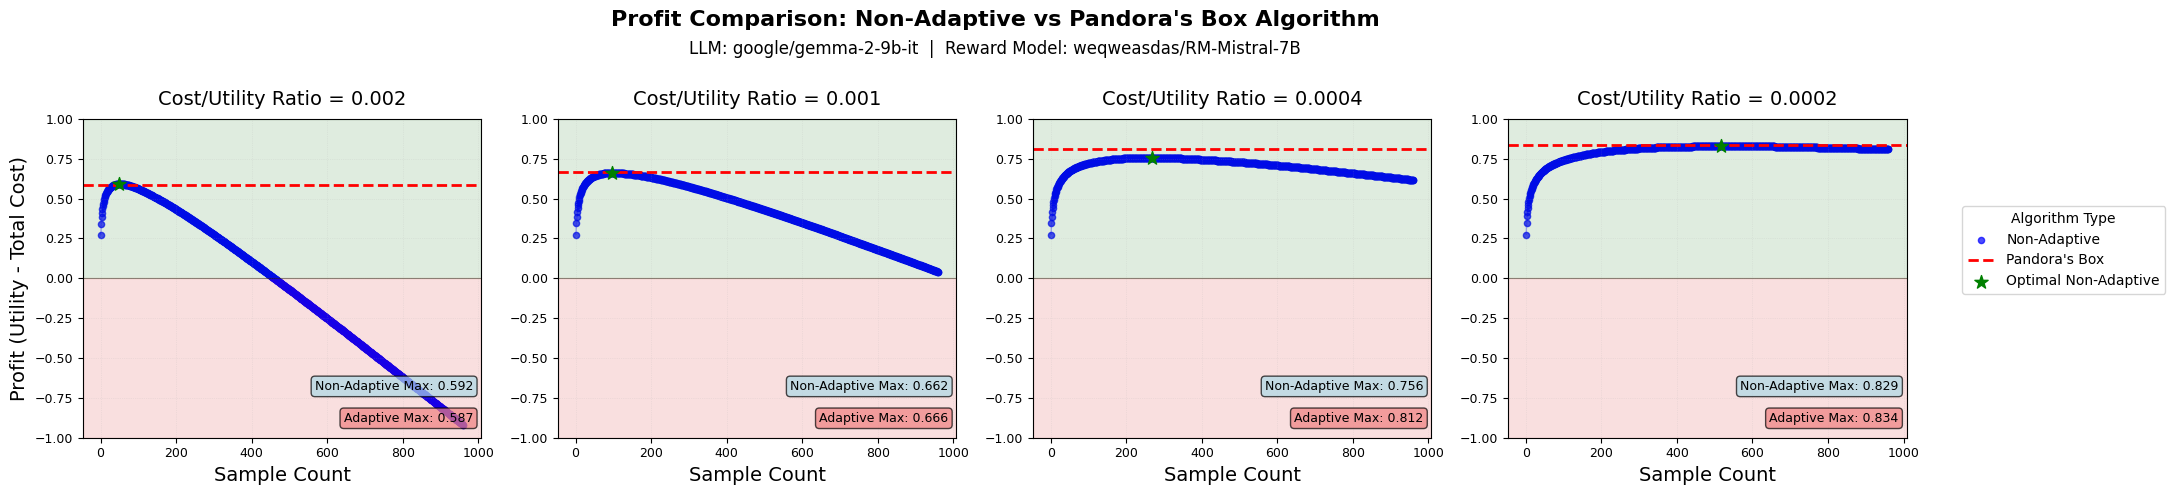

llama3.1_8b fsfairx_rm
./results5/cost_range_llama3.1_8b_fsfairx_rm_46.jsonl


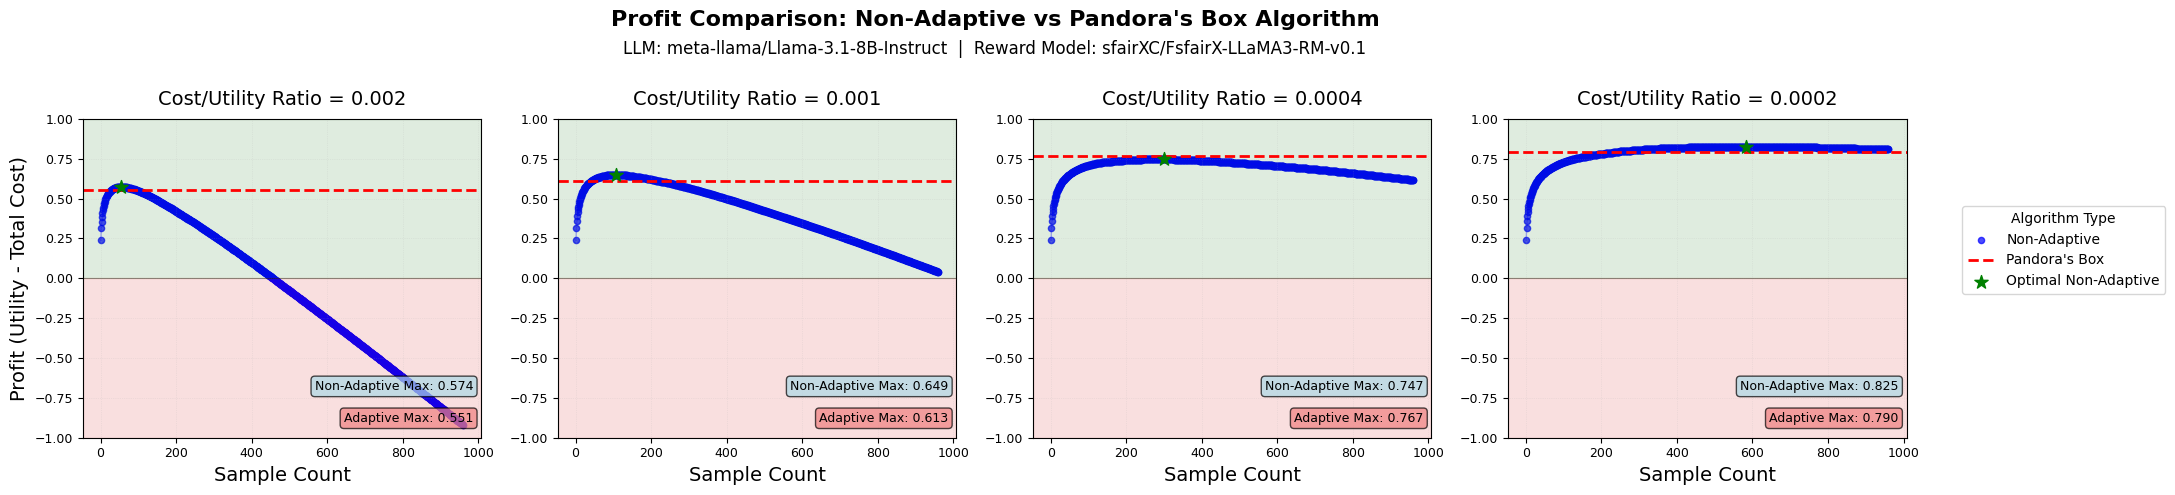

llama3.1_8b mistral_rm
./results5/cost_range_llama3.1_8b_mistral_rm_46.jsonl


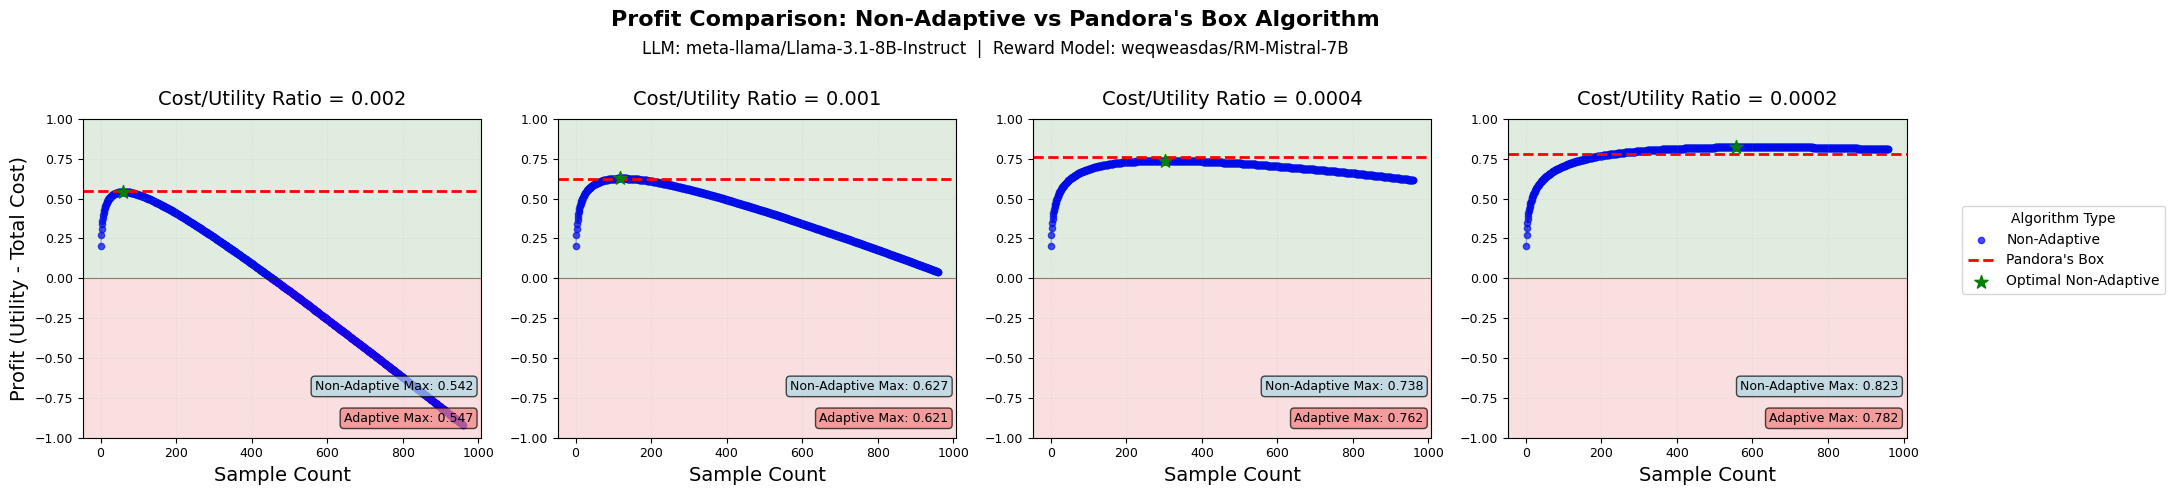

mistral_7b fsfairx_rm
./results5/cost_range_mistral_7b_fsfairx_rm_46.jsonl


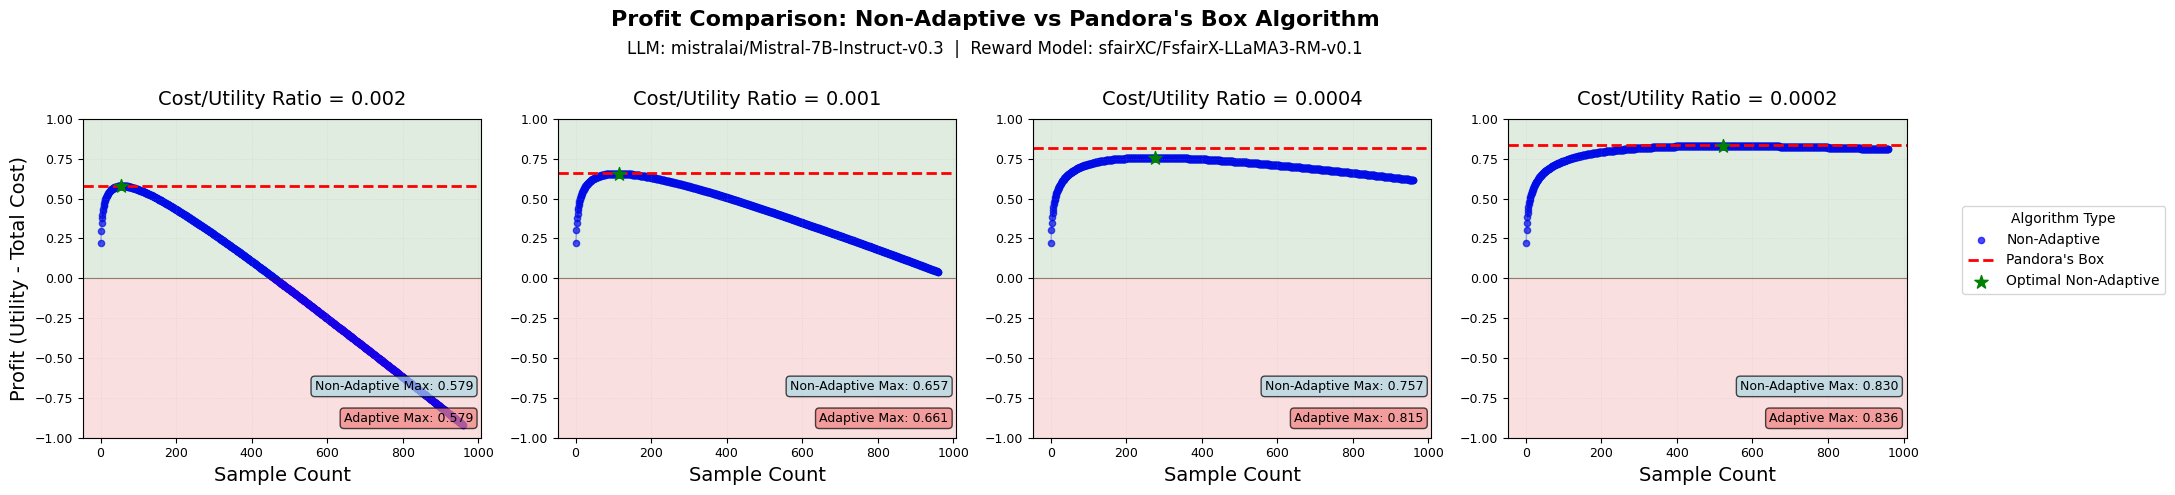

mistral_7b mistral_rm
./results5/cost_range_mistral_7b_mistral_rm_46.jsonl


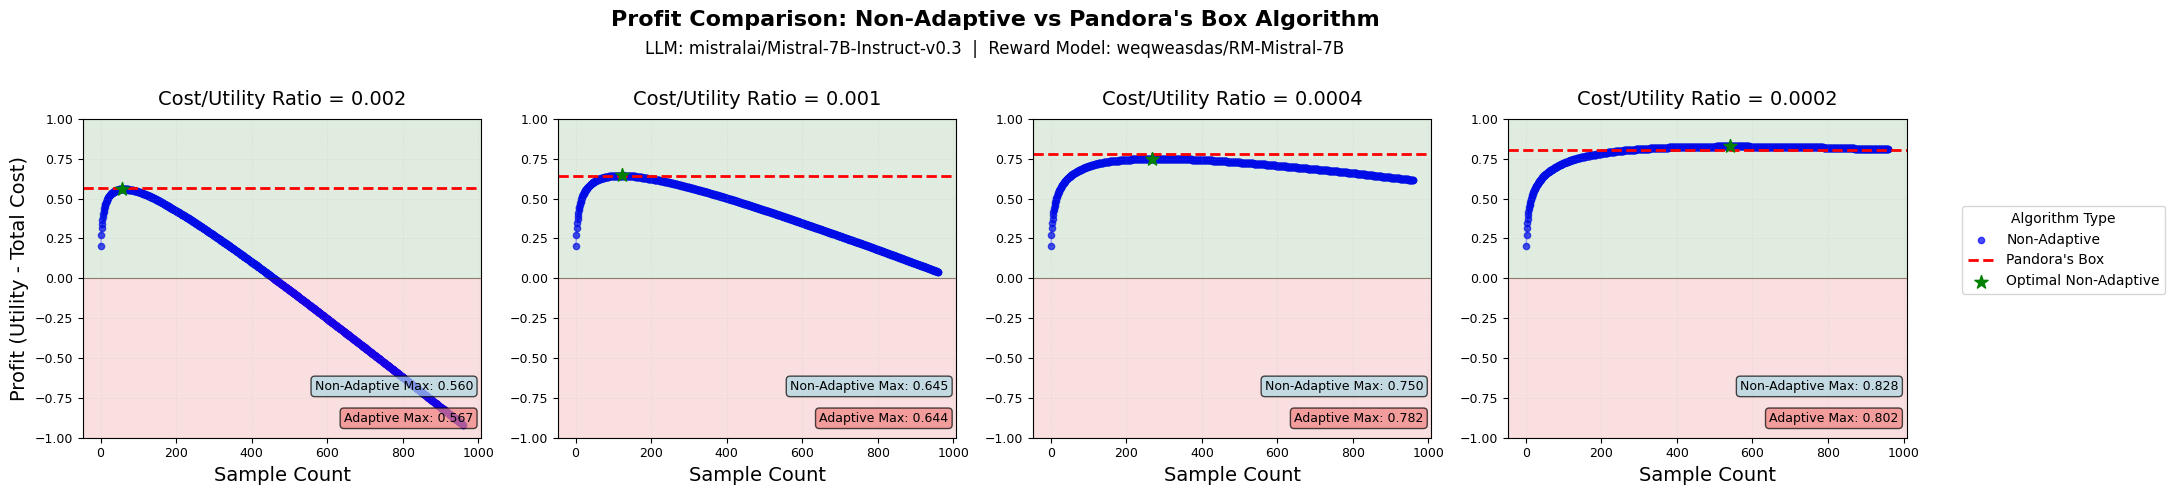

qwen2.5_7b fsfairx_rm
./results5/cost_range_qwen2.5_7b_fsfairx_rm_46.jsonl


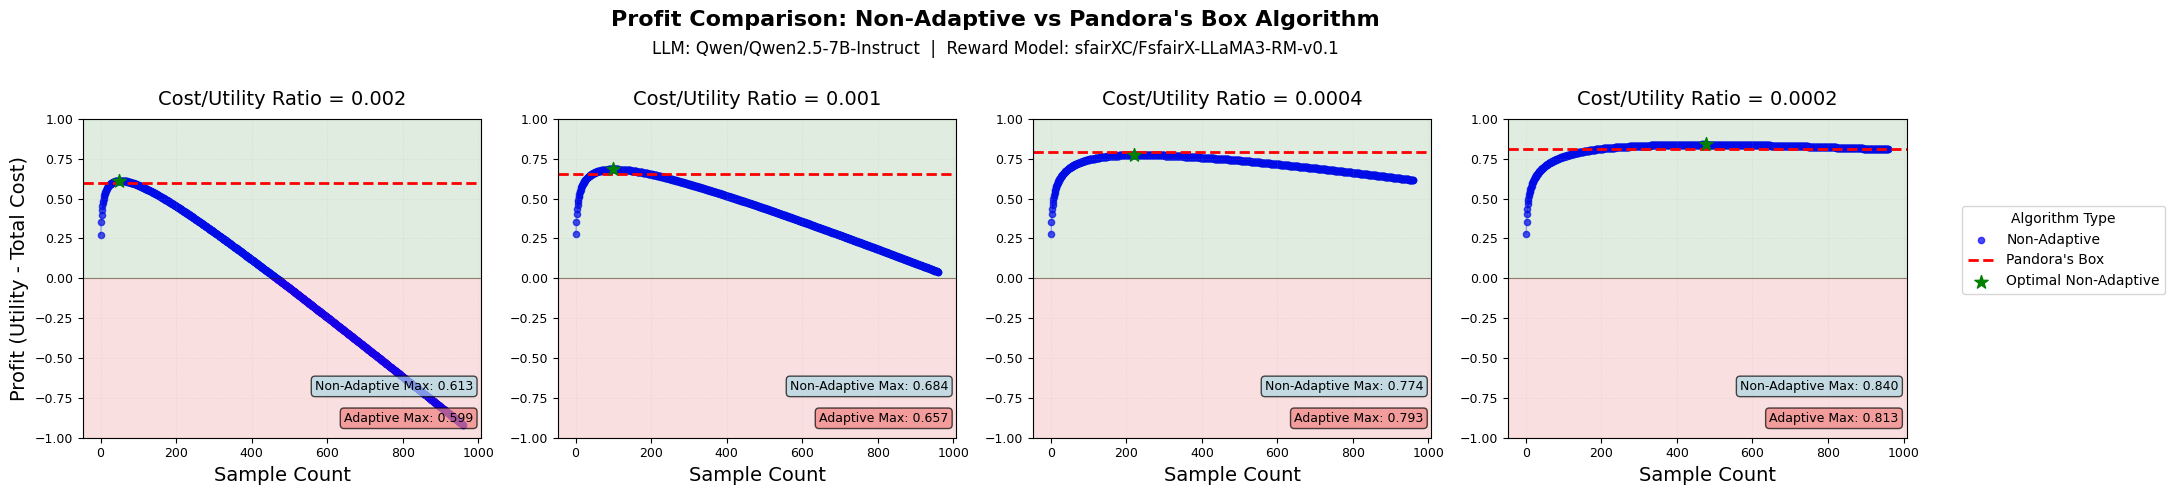

qwen2.5_7b mistral_rm
./results5/cost_range_qwen2.5_7b_mistral_rm_46.jsonl


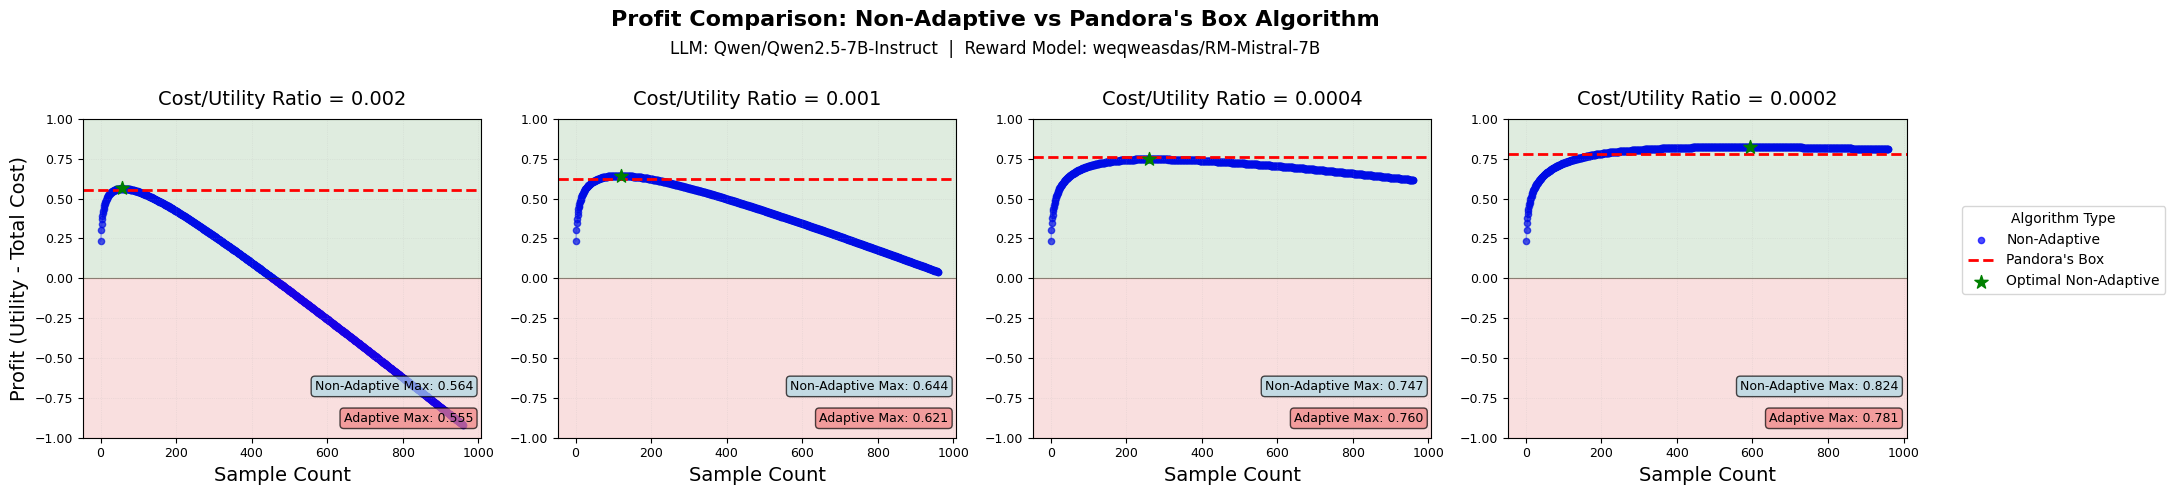

In [35]:
def run_exp(llm_name, rm_name):
    costs = []
    
    data = read_cost_analysis(llm_name, rm_name)
    for item in data[0]["a"]:
        costs.append(item["cost"])

    costs = [0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0002, 0.0001, 0.00008]
    
    costs_shortlist = [(5, 0.001), (10, 0.0005), (13, 0.0002), (14, 0.0001)]
    
    indices = [i for i in range(len(data))]
    
    NAs = []
    As = []
    for index in indices:
        NAs.append(data[index]["na"])
        As.append(data[index]["a"])
    K = len(indices)
    
    _, _, res = plot_revenue_comparison(costs_shortlist, NAs, As, K, factor=1, llm_name=llm_name, rm_name=rm_name)
    return res

RESULT_FOLDER = "./results5"
results = []
for i in [0, 1, 3, 4]:
    for j in range(2):
        print(llms[i], rms[j])
        res = run_exp(llms[i], rms[j])
        results += res

In [23]:
np.mean(results), np.median(results), np.min(results)

(np.float64(0.9171009898868752),
 np.float64(0.9564417021074867),
 np.float64(0.5840624293779734))

g* = argmax(r(g1)...r(g960))
f(g, g*) = e^(r(g))/(e^r(g) + e^r(g*))
[0, 0.5]
reward(g*) = 500
reward(g) = f(g,g*)/0.5 * reward(g*)
A(p) -> n generation -> g
cost = 1
E[reward(A)] = E[reward(g) - n] 

red line: performance of pandora;s box across 100 prompts 100 generations for each.

# Compare against best non-adaptive in all scenarios

------------------------------
Reading data from: ./results5/cost_range_gemma2_9b_mistral_rm_46.jsonl
Computed Ratios for gemma2_9b: [np.float64(0.9915114062889777), np.float64(1.0071437222612911), np.float64(1.0745973668219901), np.float64(1.0053186563008012)]
------------------------------
Reading data from: ./results5/cost_range_llama3.1_8b_mistral_rm_46.jsonl
Computed Ratios for llama3.1_8b: [np.float64(1.0091616687258413), np.float64(0.9910298639775613), np.float64(1.032468805194657), np.float64(0.9501429452707615)]
------------------------------
Reading data from: ./results5/cost_range_mistral_7b_mistral_rm_46.jsonl
Computed Ratios for mistral_7b: [np.float64(1.011358431587854), np.float64(0.9986407813759822), np.float64(1.0420397043614549), np.float64(0.9686802293910711)]
------------------------------
Reading data from: ./results5/cost_range_qwen2.5_7b_mistral_rm_46.jsonl
Computed Ratios for qwen2.5_7b: [np.float64(0.9854241102269784), np.float64(0.9650163245545246), np.float64

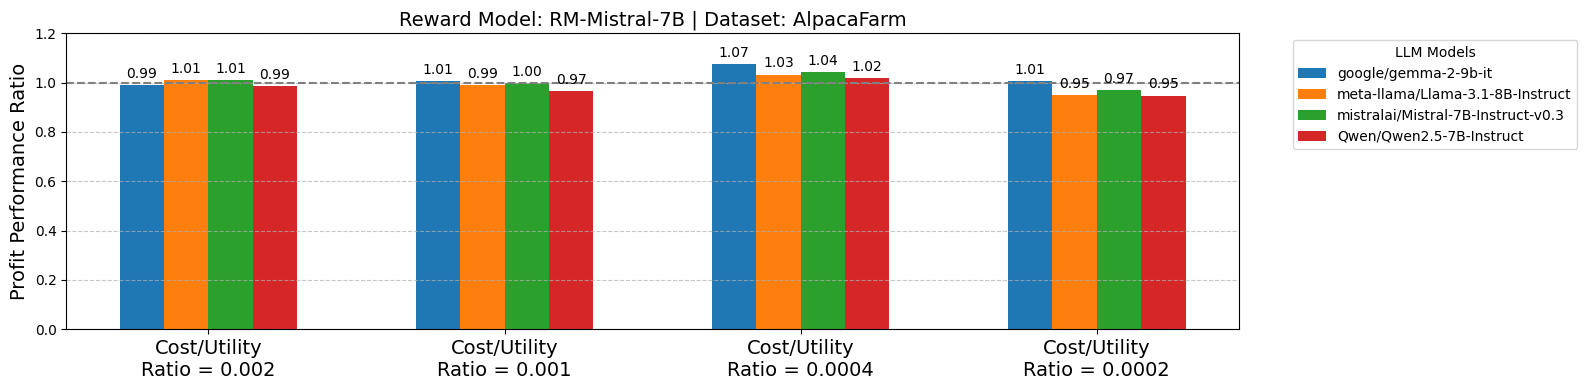

Done.


In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
RESULT_FOLDER = "./results5"
SEED = 46

# Using a shortlist of 4 LLMs for the bar chart comparison
llms_shortlist = ["gemma2_9b", "llama3.1_8b", "mistral_7b", "qwen2.5_7b"]
rms = ["fsfairx_rm", "mistral_rm"]

llm_mapping = {
    "gemma2_9b": "google/gemma-2-9b-it", 
    "llama3.1_8b": "meta-llama/Llama-3.1-8B-Instruct",
    "llama3.2_3b": "meta-llama/Llama-3.2-3B-Instruct",
    "mistral_7b": "mistralai/Mistral-7B-Instruct-v0.3",
    "qwen2.5_7b": "Qwen/Qwen2.5-7B-Instruct",
    "qwen3_4b": "Qwen/Qwen3-4B-Instruct-2507",
}

rm_mapping = {
    "fsfairx_rm": "FsfairX-LLaMA3-RM-v0.1", 
    "mistral_rm": "RM-Mistral-7B"
}

# --- Data Reading Function ---
def read_cost_analysis(llm_name, rm_name):
    """Reads the experiment log file for a given LLM and Reward Model."""
    data = []
    file_name = f"{RESULT_FOLDER}/cost_range_{llm_name}_{rm_name}_{SEED}.jsonl"
    print(f"Reading data from: {file_name}")
    try:
        with open(file_name, "r") as f:
            lines = f.readlines()
        for line in lines:
            data.append(json.loads(line))
    except FileNotFoundError:
        print(f"Error: File not found - {file_name}")
        return None
    return data

# --- Core Calculation Function ---
def compute_performance_ratios(llm_name, rm_name, costs_shortlist):
    """
    Computes the ratio of adaptive performance to the best non-adaptive performance.
    
    Returns:
    --------
    list
        A list of performance ratios for each cost in the costs_shortlist.
    """
    data = read_cost_analysis(llm_name, rm_name)
    if not data:
        return [0] * len(costs_shortlist) # Return zeros if data is missing

    K = len(data) # Number of trials/seeds
    NAs = [d["na"] for d in data]
    As = [d["a"] for d in data]
    
    ratios = []
    
    for i, c in costs_shortlist:
        # Calculate non-adaptive performances for the current cost
        non_adaptive_performances = []
        num_non_adaptive_strategies = len(NAs[0])
        for j in range(num_non_adaptive_strategies):
            # Average profit across all K trials for this specific non-adaptive strategy
            y = np.mean([2 * (NAs[k][j]["mean"] - NAs[k][j]["sample_count"] * c) for k in range(K)])
            non_adaptive_performances.append(y)
        
        # Find the best non-adaptive performance
        best_non_adaptive_perf = np.max(non_adaptive_performances)
        
        # Calculate adaptive performance (averaged over K trials)
        adaptive_perf = np.mean([2 * As[k][i]["revenue"] for k in range(K)])
        
        # Compute and store the ratio, handle division by zero
        if best_non_adaptive_perf != 0:
            ratio = adaptive_perf / best_non_adaptive_perf
        else:
            ratio = 0 # Assign 0 if the denominator is 0
            
        ratios.append(ratio)
        
    return ratios

# --- Plotting Function ---
def plot_ratios_barchart(ratios_per_llm, costs_shortlist, rm_name):
    """
    Plots a bar chart comparing the performance ratios across LLMs for different costs.
    """
    llm_labels = list(ratios_per_llm.keys())
    n_llms = len(llm_labels)
    n_costs = len(costs_shortlist)
    
    x = np.arange(n_costs)  # the label locations
    width = 0.15  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(16, 4))
    
    # Create bars for each LLM
    for i, llm_name in enumerate(llm_labels):
        ratios = ratios_per_llm[llm_name]
        offset = width * (i - (n_llms - 1) / 2)
        rects = ax.bar(x + offset, ratios, width, label=llm_mapping.get(llm_name, llm_name))
        ax.bar_label(rects, padding=3, fmt='%.2f', fontsize=10)

    # Add text, title, and labels
    ax.set_ylabel('Profit Performance Ratio', fontsize=14)
    # ax.set_title(f'Profit Performance Ratio Comparison across LLMs\nReward Model: {rm_mapping.get(rm_name, rm_name)} Dataset: AlpacaFarm', fontsize=16, fontweight='bold')
    # fig.suptitle(
    #     'Profit Performance Ratio Comparison across LLMs', 
    #     fontsize=16, 
    #     fontweight='bold'
    # )
    
    # 2. Subtitle (non-bold) for the axes
    ax.set_title(
        f'Reward Model: {rm_mapping.get(rm_name, rm_name)} | Dataset: AlpacaFarm',
        fontsize=14 # Making the subtitle slightly smaller is good practice
    )
    cost_labels = [f'Cost/Utility\nRatio = {c/0.5}' for _, c in costs_shortlist]
    ax.set_ylim([0,1.2])
    ax.set_xticks(x, cost_labels, fontsize=14)
    ax.legend(title='LLM Models', bbox_to_anchor=(1.04, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a horizontal line at y=1 for reference
    ax.axhline(y=1, color='grey', linestyle='--', linewidth=1.5, label='Baseline (Non-Adaptive)')
    
    fig.tight_layout()
    plt.show()

# Define the specific reward model and costs to analyze
target_rm_name = rms[1]  # Corresponds to "mistral_rm"
costs_shortlist = [(5, 0.001), (10, 0.0005), (13, 0.0002), (14, 0.0001)]

# Dictionary to store the results
all_ratios = {}

# Compute ratios for each LLM in the shortlist
for llm in llms_shortlist:
    print("-" * 30)
    ratios = compute_performance_ratios(llm, target_rm_name, costs_shortlist)
    all_ratios[llm] = ratios
    print(f"Computed Ratios for {llm}: {ratios}")

# Plot the final bar chart
print("\n" + "=" * 30)
print("Generating plot...")
plot_ratios_barchart(all_ratios, costs_shortlist, target_rm_name)
print("Done.")

------------------------------
Reading data from: ./results5/cost_range_gemma2_9b_fsfairx_rm_46.jsonl
Computed Ratios for gemma2_9b: [np.float64(1.008605214349889), np.float64(1.0064233519497738), np.float64(1.0719794425413662), np.float64(1.0182723220438537)]
------------------------------
Reading data from: ./results5/cost_range_llama3.1_8b_fsfairx_rm_46.jsonl
Computed Ratios for llama3.1_8b: [np.float64(0.9601418698313195), np.float64(0.9436518676386645), np.float64(1.0276692382667691), np.float64(0.9568783943973379)]
------------------------------
Reading data from: ./results5/cost_range_mistral_7b_fsfairx_rm_46.jsonl
Computed Ratios for mistral_7b: [np.float64(1.0003288519058062), np.float64(1.0058188298368025), np.float64(1.0769698967228305), np.float64(1.0068780625661784)]
------------------------------
Reading data from: ./results5/cost_range_qwen2.5_7b_fsfairx_rm_46.jsonl
Computed Ratios for qwen2.5_7b: [np.float64(0.97717405564992), np.float64(0.9599813817010926), np.float64(

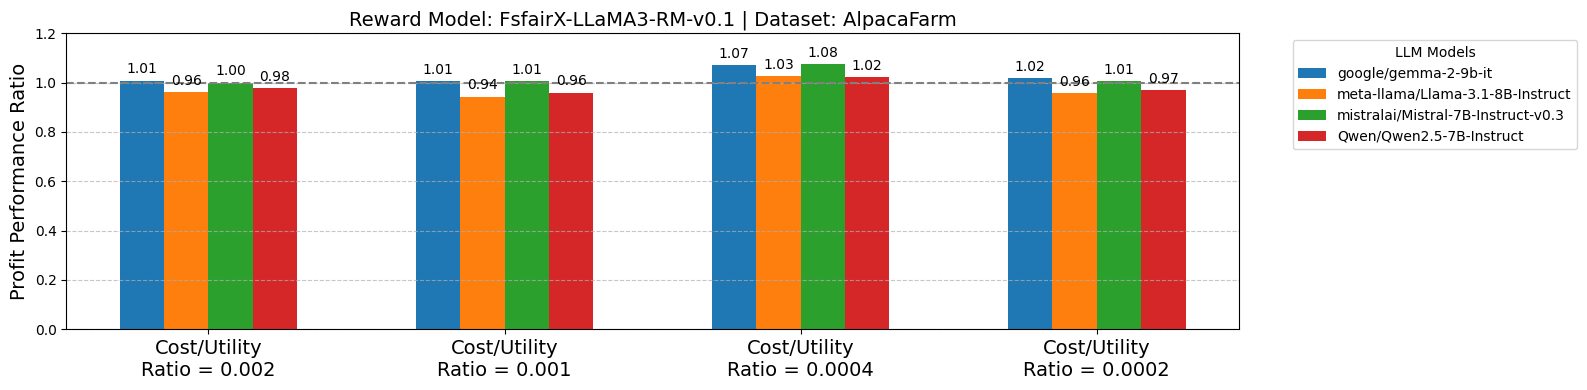

Done.


In [30]:
# Define the specific reward model and costs to analyze
target_rm_name = rms[0]  # Corresponds to "mistral_rm"
costs_shortlist = [(5, 0.001), (10, 0.0005), (13, 0.0002), (14, 0.0001)]

# Dictionary to store the results
all_ratios = {}

# Compute ratios for each LLM in the shortlist
for llm in llms_shortlist:
    print("-" * 30)
    ratios = compute_performance_ratios(llm, target_rm_name, costs_shortlist)
    all_ratios[llm] = ratios
    print(f"Computed Ratios for {llm}: {ratios}")

# Plot the final bar chart
print("\n" + "=" * 30)
print("Generating plot...")
plot_ratios_barchart(all_ratios, costs_shortlist, target_rm_name)
print("Done.")